In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error


## La Serie

In [2]:
import pandas as pd
import tensorflow as tf
from datetime import datetime

tf.random.set_seed(123)

# Leer el archivo Excel y parsear la fecha
df = pd.read_excel("Datos Originales/Importacion.xlsx")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.set_index("Fecha", inplace=True)

# Filtrar únicamente la columna de Gasolina regular
serie = df[["Gasolina regular"]].dropna()

print('\n Datos parseados:')
serie.head()


 Datos parseados:


,Gasolina regular
Fecha,
2001-01-01,177776.50
2001-02-01,123115.99
2001-03-01,161726.42
2001-04-01,127338.74
2001-05-01,168730.19


A continuación podemos ver el gráfico de la serie. 

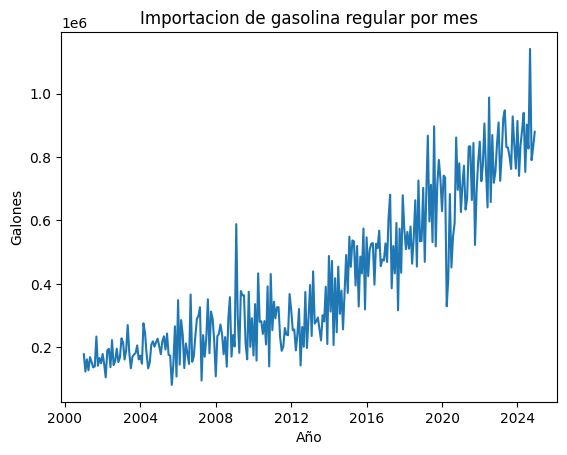

In [3]:
plt.plot(serie)
plt.gca().set(title="Importacion de gasolina regular por mes", xlabel="Año", ylabel="Galones")
plt.show()

(Como se puede ver la serie no es estacionaria en media y la LSTM funciona mejor con series estacionarizadas así que vamos a diferenciarla na vez a ver si es suficiente para estacionarizarla en media)

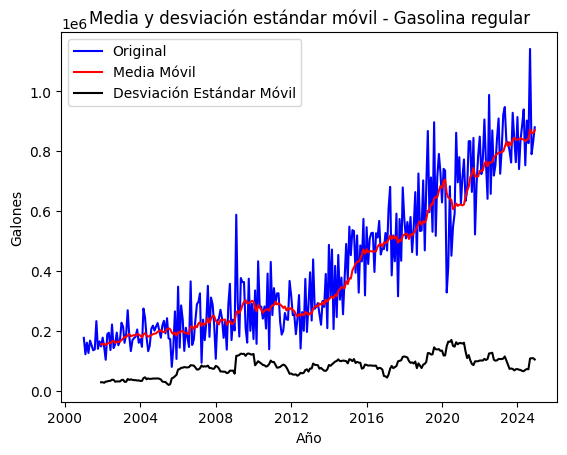

In [4]:
# Calcular media móvil y desviación estándar móvil de los últimos 12 meses
mediaMovil = serie.rolling(window=12).mean()
deMovil = serie.rolling(window=12).std()

# Graficar resultados
plt.plot(serie, color="blue", label="Original")
plt.plot(mediaMovil, color='red', label='Media Móvil')
plt.plot(deMovil, color='black', label='Desviación Estándar Móvil')
plt.legend(loc='best')
plt.title('Media y desviación estándar móvil - Gasolina regular')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.show()

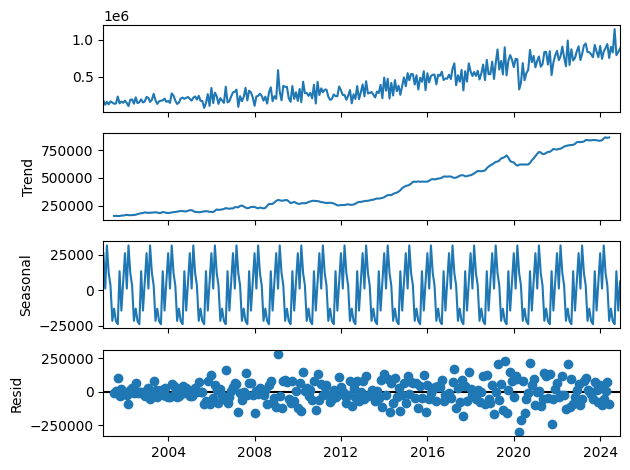

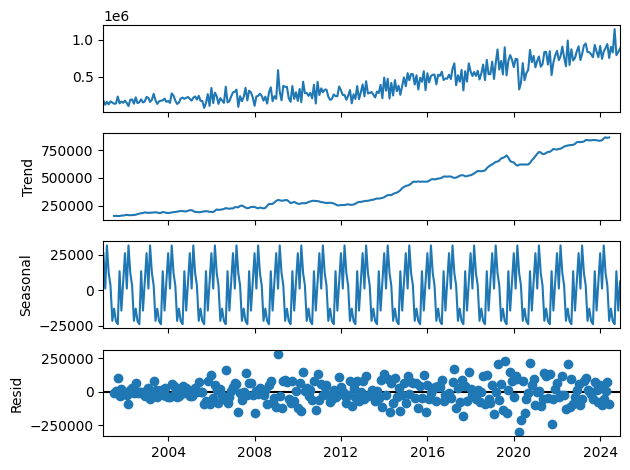

In [5]:
descomposicion = seasonal_decompose(serie)
descomposicion.plot()

En este gráfico se puede observar que hay tendencia por lo que la serie no parece ser estacionaria en media y tampoco en varianza.

In [6]:
from statsmodels.tsa.stattools import adfuller

print('Resultados del Test de Dickey-Fuller para Gasolina Regular')
dfTest = adfuller(serie["Gasolina regular"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=[
    'Estadístico de prueba',
    'p-value',
    '# de retardos usados',
    '# de observaciones usadas'
])
for key, value in dfTest[4].items():
    salidaDf[f'Valor crítico ({key})'] = value

print(salidaDf)

Resultados del Test de Dickey-Fuller para Gasolina Regular
Estadístico de prueba          0.830167
p-value                        0.992108
# de retardos usados           9.000000
# de observaciones usadas    278.000000
Valor crítico (1%)            -3.454094
Valor crítico (5%)            -2.871993
Valor crítico (10%)           -2.572340
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias, es decir, tiene una tendencia o depende mucho de su valor pasado (no es estacionaria). 

Como la serie no es estacionaria en media, vamos a probar con una diferenciación

In [7]:
print('Resultados del Test de Dickey-Fuller para una diferenciación de la serie Gasolina Regular')

# Diferenciar la serie
serie_diff = serie["Gasolina regular"].diff()
serie_diff.fillna(0, inplace=True)

# Prueba de Dickey-Fuller sobre la serie diferenciada
dfTest = adfuller(serie_diff)
salidaDf = pd.Series(dfTest[0:4], index=[
    'Estadístico de prueba',
    'p-value',
    '# de retardos usados',
    '# de observaciones usadas'
])
for key, value in dfTest[4].items():
    salidaDf['Valor crítico (%s)' % key] = value

print(salidaDf)

Resultados del Test de Dickey-Fuller para una diferenciación de la serie Gasolina Regular
Estadístico de prueba       -1.023316e+01
p-value                      4.967668e-18
# de retardos usados         8.000000e+00
# de observaciones usadas    2.790000e+02
Valor crítico (1%)          -3.454008e+00
Valor crítico (5%)          -2.871956e+00
Valor crítico (10%)         -2.572320e+00
dtype: float64


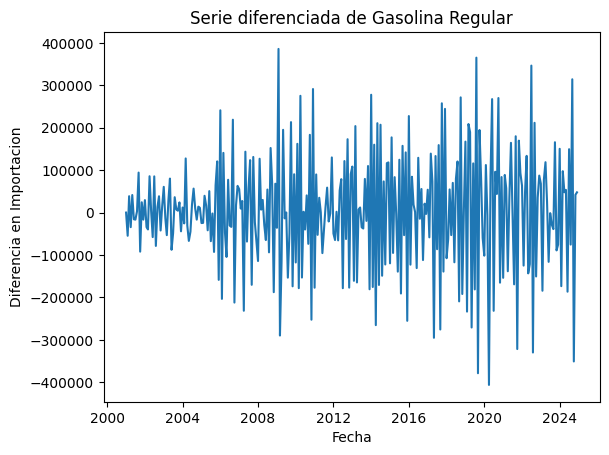

In [8]:
plt.plot(serie_diff)
plt.title("Serie diferenciada de Gasolina Regular")
plt.xlabel("Fecha")
plt.ylabel("Diferencia en Importacion")
plt.show()

Como ya han podido explorarlo, las redes neuronales (como LSTM) son sensibles a la escala de los datos. Si hay valores grandes, junto con pequeños, la red puede tener dificultades al aprender, especialmente usando funciones de activación como tanh o sigmoid. (Además que esto facilita el entrenamiento). 

Como las redes neuronales trabajan mejor con los datos normalizados, vamos a normalizar la serie. 

Al normalizarla, estamos haciendo que la data tenga una media de 0 y una desviación estándar de 1. 

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
serie_diff_scaled = scaler.fit_transform(serie_diff.values.reshape(-1, 1))
serie_diff_scaled[:6]

array([[-0.01786488],
       [-0.41838396],
       [ 0.26504895],
       [-0.26983695],
       [ 0.28542658],
       [-0.13386558]])

Vamos a separar la serie en entrenamiento, validación y prueba. En este caso, tendremos 60% para entrenamiento y 20% para validación y prueba respectivamente.

In [10]:
# Largo total de la serie
total_len = len(serie_diff_scaled)

# Definir proporciones
train_prop = 0.6
val_prop = 0.2
test_prop = 0.2 

# Calcular índices
train_end = int(train_prop * total_len)
val_end = train_end + int(val_prop * total_len)

# Separar sin solapamientos
train = serie_diff_scaled[:train_end]
validation = serie_diff_scaled[train_end:val_end]
test = serie_diff_scaled[val_end:]

# Redimensionar para modelos tipo LSTM
train = train.reshape(-1, 1)
validation = validation.reshape(-1, 1)
test = test.reshape(-1, 1)

# Verificar tamaños
print(f"Total registros: {total_len}")
print(f"Train: {len(train)} | Validation: {len(validation)} | Test: {len(test)}")

Total registros: 288
Train: 172 | Validation: 57 | Test: 59


In [11]:
train, type(train)

(array([[-0.01786488],
        [-0.41838396],
        [ 0.26504895],
        [-0.26983695],
        [ 0.28542658],
        [-0.13386558],
        [-0.13949932],
        [ 0.00460047],
        [ 0.67295214],
        [-0.69267044],
        [ 0.1601266 ],
        [-0.13967393],
        [ 0.19732793],
        [-0.26801243],
        [-0.30930178],
        [ 0.60983895],
        [ 0.01504318],
        [-0.44123656],
        [ 0.60758094],
        [-0.59389328],
        [ 0.07857755],
        [ 0.26401923],
        [-0.32738205],
        [ 0.08773027],
        [ 0.42670855],
        [-0.11882757],
        [-0.40792564],
        [ 0.19145981],
        [ 0.56947678],
        [-0.66067977],
        [-0.37387385],
        [ 0.24764807],
        [ 0.03572526],
        [ 0.01474566],
        [ 0.15767056],
        [-0.34134257],
        [ 0.06969381],
        [-0.20462549],
        [ 0.91711167],
        [-0.24049338],
        [-0.50710426],
        [-0.34794052],
        [ 0.11941201],
        [ 0

In [12]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)


In [13]:
x_train

array([[-0.01786488],
       [-0.41838396],
       [ 0.26504895],
       [-0.26983695],
       [ 0.28542658],
       [-0.13386558],
       [-0.13949932],
       [ 0.00460047],
       [ 0.67295214],
       [-0.69267044],
       [ 0.1601266 ],
       [-0.13967393],
       [ 0.19732793],
       [-0.26801243],
       [-0.30930178],
       [ 0.60983895],
       [ 0.01504318],
       [-0.44123656],
       [ 0.60758094],
       [-0.59389328],
       [ 0.07857755],
       [ 0.26401923],
       [-0.32738205],
       [ 0.08773027],
       [ 0.42670855],
       [-0.11882757],
       [-0.40792564],
       [ 0.19145981],
       [ 0.56947678],
       [-0.66067977],
       [-0.37387385],
       [ 0.24764807],
       [ 0.03572526],
       [ 0.01474566],
       [ 0.15767056],
       [-0.34134257],
       [ 0.06969381],
       [-0.20462549],
       [ 0.91711167],
       [-0.24049338],
       [-0.50710426],
       [-0.34794052],
       [ 0.11941201],
       [ 0.39625817],
       [ 0.05472314],
       [-0

In [14]:
y_train, type(y_train)

(array([-0.41838396,  0.26504895, -0.26983695,  0.28542658, -0.13386558,
        -0.13949932,  0.00460047,  0.67295214, -0.69267044,  0.1601266 ,
        -0.13967393,  0.19732793, -0.26801243, -0.30930178,  0.60983895,
         0.01504318, -0.44123656,  0.60758094, -0.59389328,  0.07857755,
         0.26401923, -0.32738205,  0.08773027,  0.42670855, -0.11882757,
        -0.40792564,  0.19145981,  0.56947678, -0.66067977, -0.37387385,
         0.24764807,  0.03572526,  0.01474566,  0.15767056, -0.34134257,
         0.06969381, -0.20462549,  0.91711167, -0.24049338, -0.50710426,
        -0.34794052,  0.11941201,  0.39625817,  0.05472314, -0.13943784,
         0.08421048,  0.06461512, -0.19900084, -0.19569787,  0.27202858,
         0.10541369, -0.32383948,  0.35296925, -0.51171202, -0.0335156 ,
        -0.69781097,  0.45336238,  0.86649821, -1.18031465,  1.74898848,
        -1.50866454,  1.01335625, -0.36194932, -0.78440047,  0.54891226,
        -0.24223378, -0.26477379,  1.58645539, -1.5


## Creando el modelo
Para que pueda hacerse el modelo se le tiene que suministrar una matriz de 3 dimensiones siendo estas:
- ***Muestras:*** número de observaciones en cada lote (batch), también conocido como tamaño del lote (batch size).
- ***Pasos de tiempo:*** Pasos de tiempo separados para una observación dada. En este ejemplo los pasos de tiempo = 1
- ***Características:*** Para un caso univariante, como en este ejemplo, las características = 1  

Vamos a convertir los conjuntos en matrices de 3 dimensiones
(n_samples, time_steps, n_features)

In [15]:
(x_train.shape[0],1,1)

(171, 1, 1)

In [16]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

56

### Creamos el modelo.   
Vamos a utilizar solo una capa lstm  

LSTM(units, input_shape=(pasos, características), stateful=False)
- units: cantidad de neuronas. Cada una es como una "mini-memoria" que puede aprender patrones en secuencias.
- input_shape: pasos (lags) y features (cant de variables)
- batch_input_shape: Solo se usa si stateful=True. Igual que input_shape, pero le agregas el tamaño fijo del batch (batch_size). O sea: (batch_size, pasos, características).
- stateful: mantiene el estado (memoria) entre batches, ayuda para entender dependencias a largo plazo entre batches

Dense(1)
#
- Toma lo que sale de la LSTM y le aplica una transformación lineal con pesos y bias.
- En este caso, Dense(1) significa: produce una sola salida (por ejemplo, una predicción de un número, como el siguiente valor de la serie).

In [17]:
unidades =  10
paso = 1 # lags, 1 lag es un mes. 
caracteristicas = 1 # es univariada
lote = 1


modelo1 = Sequential()
modelo1.add(LSTM(
    units=unidades, 
    input_shape=(paso, caracteristicas), 
    stateful=False  # desactivamos estado entre batches
))

# modelo1.add(LSTM(
#     units=unidades, 
#     batch_input_shape=(lote, paso, caracteristicas), 
#     stateful=True  # activamos estado entre batches
# ))
modelo1.add(Dense(1))
modelo1.summary()

c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

Compilamos el modelo. Las métricas que nos van a servir para saber como funciona el modelo en términos de la pérdida es el error medio cuadrado. 

In [18]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

Vamos a entrenar el modelo. Para eso configuramos las epochs(épocas) que es la cantidad de iteraciones. Lo pondremos en 50.

In [19]:
epocas = 100
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3707 - val_loss: 1.2728
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3396 - val_loss: 1.1282
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3108 - val_loss: 0.9939
Epoch 4/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2870 - val_loss: 0.8857
Epoch 5/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2712 - val_loss: 0.8122
Epoch 6/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2633 - val_loss: 0.7685
Epoch 7/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2605 - val_loss: 0.7445
Epoch 8/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2601 - val_loss: 0.7316
Epoch 9/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2605 - val_loss: 0.7248
Epoch 10/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2610 - val_loss: 0.7212
Epoch 11/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2613 - val_loss: 0.7192
Epoch 12/100
171/171 ━━━━━━━━━━━━━━━━━━━

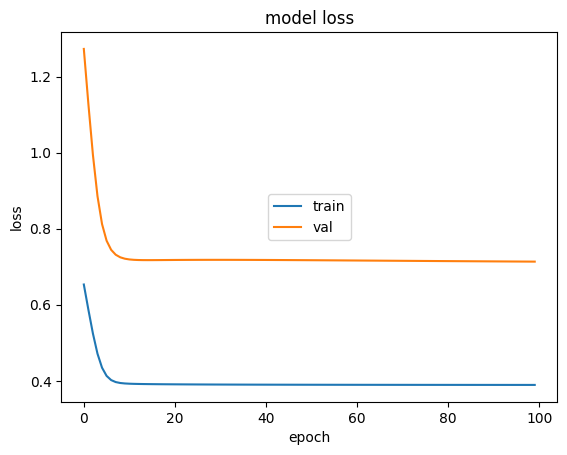

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

Evaluemos ahora el modelo según la pérdida en cada uno de los conjuntos de datos.

In [21]:
print("Pérdida en Train")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3045 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.6418
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.1243


1.026665449142456

Ahora vamos a predecir con el modelo 1.  

In [22]:
def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    # Convertir data en la forma correcta (suponiendo que cada entrada es un vector)
    X = np.reshape(data, (data.shape[0], 1, data.shape[1]))  # Ajuste según las dimensiones
    yhat = modelo.predict(X, batch_size=batch_size, verbose=0)  # Predicción en lote
    
    # Invertir el escalado
    yhat = scaler.inverse_transform(yhat)
    
    if dif:
        # Invertir la diferencia para todo el lote a la vez
        for i in range(len(yhat)):
            yhat[i] += Series[(n + dif_cant * i)]  # Invertir la diferencia
    return yhat.flatten()  # Retornar un vector plano con las predicciones

# Predicciones
prediccion_val1 = prediccion_fun(x_val, modelo1, 1, scaler, dif=True, dif_cant=1, Series=serie.values, n=train_end)
prediccion_test1 = prediccion_fun(x_test, modelo1, 1, scaler, dif=True, dif_cant=1, Series=serie.values, n=len(serie.values) - len(x_test))


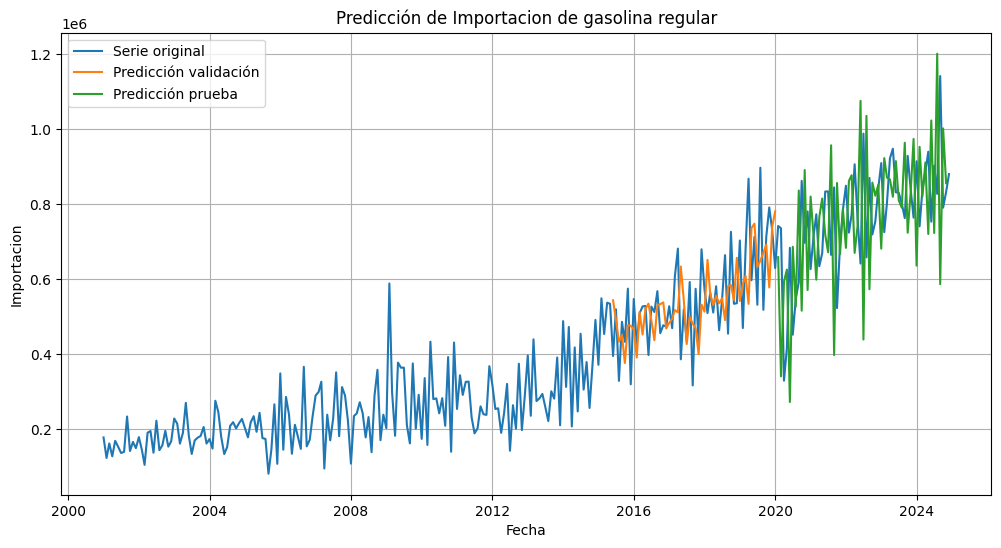

In [23]:
# df_val = pd.DataFrame(prediccion_val,index=serie[(train_prop):train_prop+val_prop].index) 
# df_test = pd.DataFrame(prediccion_test,index=serie[train_prop+len(df_val):len(serie)].index)
df_val = pd.DataFrame(prediccion_val1, index=serie[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test1, index=serie[val_end:].index[:len(prediccion_test1)])


plt.figure(figsize=(12,6))
plt.plot(serie, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.title('Predicción de Importacion de gasolina regular')
plt.xlabel('Fecha')
plt.ylabel('Importacion')
plt.grid(True)
plt.show()



### Modelo 2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Parámetros
unidades = 50
paso = 12
caracteristicas = 1

# Crear el modelo
modelo2 = Sequential()

# Primera capa LSTM
modelo2.add(LSTM(
    units=unidades, 
    return_sequences=True,  # Necesario para apilar otra capa LSTM
    input_shape=(paso, caracteristicas),
    stateful=False
))
modelo2.add(Dropout(0.2))  # Regularización

# Segunda capa LSTM
modelo2.add(LSTM(
    units=25,
    stateful=False
))
modelo2.add(Dropout(0.2))  # Regularización

# Capa de salida
modelo2.add(Dense(1))  # Predicción

# Resumen del modelo
modelo2.summary()

# Compilación del modelo
modelo2.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
modelo2.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))


c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,026 (70.41 KB)

 Trainable params: 18,026 (70.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 0.7044 - val_loss: 1.4280
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6927 - val_loss: 1.4095
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.6783 - val_loss: 1.3910
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.6670 - val_loss: 1.3714
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.6572 - val_loss: 1.3506
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.6426 - val_loss: 1.3277
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6288 - val_loss: 1.3022
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.6096 - val_loss: 1.2735
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.5957 - val_loss: 1.2420
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.5756 - val_loss: 1.2078
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.5484 - val_loss: 1.1713
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.5273 - val_loss: 1.1342


In [26]:
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

In [27]:
epocas = 50
history= modelo2.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2701 - val_loss: 0.7148
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2673 - val_loss: 0.7098
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2715 - val_loss: 0.7068
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2656 - val_loss: 0.7031
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2714 - val_loss: 0.7048
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2612 - val_loss: 0.6995
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2722 - val_loss: 0.6995
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2676 - val_loss: 0.7010
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2663 - val_loss: 0.7014
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2676 - val_loss: 0.7015
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2631 - val_loss: 0.7016
Epoch 12/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s

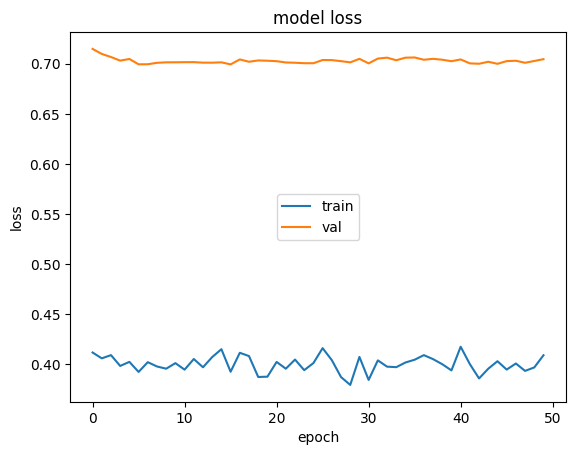

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [29]:
print("Pérdida en Train")
modelo2.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo2.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Test")
modelo2.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Train
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3068 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6322
Pérdida en Test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.1379


1.0406441688537598

In [30]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        # X = np.reshape(X,(1,1,1))
        X = np.reshape(X, (1,) + X.shape)
        yhat = modelo2.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion


prediccion_val2 = prediccion_fun(x_val,modelo2, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n=train_end)
prediccion_test2 = prediccion_fun(x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = serie.values , n = len(serie.values) - len(x_test))

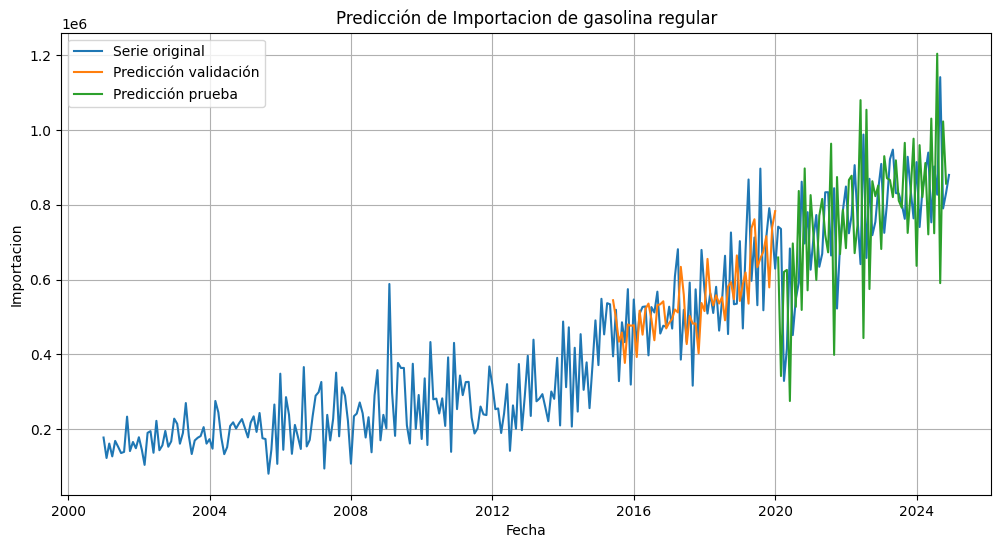

In [31]:
# df_val = pd.DataFrame(prediccion_val,index=serie[(train_prop):train_prop+val_prop].index) 
# df_test = pd.DataFrame(prediccion_test,index=serie[train_prop+len(df_val):len(serie)].index)
df_val = pd.DataFrame(prediccion_val2, index=serie[train_end+1:val_end].index)
df_test = pd.DataFrame(prediccion_test2, index=serie[val_end:].index[:len(prediccion_test2)])


plt.figure(figsize=(12,6))
plt.plot(serie, label='Serie original')
plt.plot(df_val, label='Predicción validación')
plt.plot(df_test, label='Predicción prueba')
plt.legend()
plt.title('Predicción de Importacion de gasolina regular')
plt.xlabel('Fecha')
plt.ylabel('Importacion')
plt.grid(True)
plt.show()

In [33]:
# --- Modelo 1 ---
rmse_val_1 = np.sqrt(mean_squared_error(y_val, prediccion_val1))
rmse_test_1 = np.sqrt(mean_squared_error(y_test, prediccion_test1))

# --- Modelo 2 ---
rmse_val_2 = np.sqrt(mean_squared_error(y_val, prediccion_val2))
rmse_test_2 = np.sqrt(mean_squared_error(y_test, prediccion_test2))

# Mostrar resultados
print(f"Modelo 1 - RMSE validación: {rmse_val_1:.2f} | RMSE prueba: {rmse_test_1:.2f}")
print(f"Modelo 2 - RMSE validación: {rmse_val_2:.2f} | RMSE prueba: {rmse_test_2:.2f}")


Modelo 1 - RMSE validación: 549495.47 | RMSE prueba: 785752.16
Modelo 2 - RMSE validación: 553587.45 | RMSE prueba: 789888.55
